In [19]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ./setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import utils.utils_funcs as utils
import run_functions as rf
from subsets_analysis import Subsets
import pickle
mean = np.nanmean  # lots of arrays to be meaned have nans

## Loading the Data

In [3]:
# dictionary of mice and run numbers to analyse
run_dict = {
            'J048' : [27, 29, 30, 32], 
            'RL048': [23, 24, 25, 28, 29]
           }

In [4]:
# local path to behaviour pickle files
# this takes a while to load so maybe should do some further caching in the future
pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/'

runs = []
for mouse in run_dict:
    for run_number in run_dict[mouse]:
        run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
        with open(run_path, 'rb') as f:
            r = pickle.load(f)
            runs.append(r)

In [5]:
runs[0].__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path', 'flu_raw', 'frames_ms', 'frames_ms_pre', 'flu', 'spks', 'stat'])

## Basic attributes of the run object

In [6]:
# toggle this cell on if you want to use raw fluoresence instead of processed (neuropil subtracted and Df/f)
# for i in range(len(runs)):
#     runs[i].flu = runs[i].flu_raw    

In [7]:
# processed (neuropil subtracted and Df/f) fluoresence matrix from first run
flu = runs[0].flu
print('This run has {} cells and {} frames'.format(flu.shape[0], flu.shape[1]))

This run has 2101 cells and 16117 frames


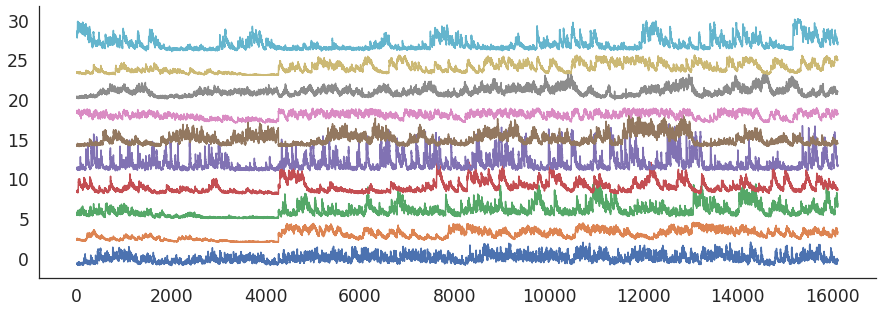

In [20]:
# plot the first 10 cells in the first run
plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(flu[i,:] + i*3)

In [9]:
# run objects have info from the suite2p stat (1xdictionary per cell
# used to e.g. find the plane each cell is in
plane0_idx = [idx for idx, s in enumerate(runs[0].stat) if s['iplane']==0]

## Alignment between behaviour and imaging

In [10]:
#### two timestamps for the onset of photostimulation ####

# when is voltage sent to the x photostimulation galvo
tstart_galvo = utils.threshold_detect(runs[0].x_galvo_uncaging, 0)

# when did the behaviour microcontroller trigger a trial start
trial_start = runs[0].trial_start

assert len(trial_start) == len(tstart_galvo)

In [11]:
#### these two timestamp variables are in a different reference frame ####

# run objects have an aligner method to switch between reference frames
galvo_ms = runs[0].aligner.B_to_A(tstart_galvo)

print('microcontroller trial starts occur on average {} ms from galvo trial starts'
      .format(round(np.mean(trial_start - galvo_ms), 2)))

microcontroller trial starts occur on average -36.39 ms from galvo trial starts


In [12]:
## To know which frames behavioural events occured on, use the frames_ms matrix.
## This tells you the time in ms (in the behaviour microcontroller reference frames) 
## that each frame occured on.
## frames_ms == nan when no behaviour was recorded
assert runs[0].frames_ms.shape == runs[0].flu.shape

## Behavioural information

In [13]:
### a different number of cells were stimulated on each trial
### need to create a Subsets object to get this info (future code refinement will
### include this info directly in the run object
subsets = Subsets(runs[0])
trial_subsets = subsets.trial_subsets
print(trial_subsets[5:20])
### the result of the behavioural trial is in the run.oucome array
outcome = runs[0].outcome
print(outcome[5:20])
assert len(runs[0].outcome) == len(tstart_galvo) == len(subsets.trial_subsets)

[  5   0   5  30   0   0   0  30   0   0 150   5   0 150 150]
['hit' 'fp' 'hit' 'hit' 'fp' 'fp' 'cr' 'hit' 'fp' 'fp' 'hit' 'miss' 'cr'
 'hit' 'hit']


(40000, 50000)

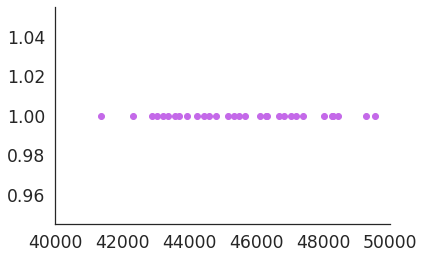

In [21]:
## behaviour 'choice' is recorded through the mouse licking a water spout
licks = runs[0].session.times.get('lick_1')
utils.raster_plot(licks)
plt.xlim((40000,50000))

## Process data using utility functions

In [15]:
# remove cells from future processing that have unbiological df/f values
# runs = [rf.filter_unhealthy_cells(run, threshold=5) for run in runs]
# run object with only cells in s2
runs_s2 = [rf.select_s2(run) for run in runs]
# list of arrays of trials where the mouse is performing well in the task
good_trials = [rf.filter_trials(run) for run in runs]

## Build trial by trial arrays from fluoresence data

In [16]:
# the number of frames before trial start to take into array
pre_frames = 20
# the number of frames after trial start to take into array
post_frames = 30
# array of fluoresence through behavioural trials (n_cells x n_trials x n_frames)
# with e.g. the first trials spanning (galvo_ms[0] - pre_frames) : (galvo_ms[0] + post_frames)
behaviour_trials = utils.build_flu_array(runs[0], galvo_ms, pre_frames, post_frames)

# array of spontaneous fluoresence pseudo-trials (n_cells x n_trials x n_frames)
spont_trials = rf.get_spont_trials(runs[0], pre_frames, post_frames,
                                   n_trials=behaviour_trials.shape[1])
spont_trials.shape

(1085, 143, 50)

In [17]:
# trials where a hit was scored. Don't include trials where 150 cells
# were stimulated as this has a longer artifact
hit_idx = np.where((outcome=='hit') & (trial_subsets!=150))[0]
hit_trials = behaviour_trials[:, hit_idx, :]

(15, 28)

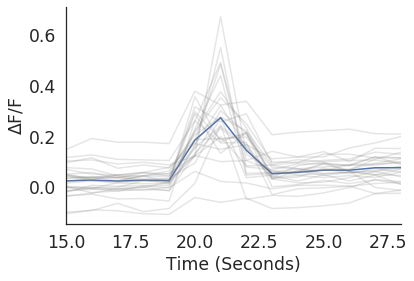

In [22]:
fs = 5  # frame rate
x_axis = (np.arange(-pre_frames, post_frames) + 1) / fs
#x_axis = np.arange(-pre_frames, post_frames)
x_axis = range(hit_trials.shape[2])
# mean across cells and trials
plt.plot(x_axis, mean(mean(hit_trials, 0), 0))


ts = mean(hit_trials,0)

for t in ts:
    plt.plot(x_axis, t, color='grey', alpha=0.2)

plt.axvline(x=0, color='pink')
plt.axvline(x=0.25, color='pink')

plt.xlabel('Time (Seconds)')
plt.ylabel(r'$\Delta $F/F')
plt.xlim((15,28))